# Strategies

In [1]:
import os
while not os.path.isfile('config.yaml'):
    os.chdir("../")
from pathlib import Path
directory = Path('./statistics')

def parse_stats(line):
    line = line.split(';')
    return {
        'sl':float(line[0]),
        'tp':float(line[1]),
        'n_windows':float(line[2]),
        'n_trades':float(line[3]),
        'trade_rate':float(line[4]),
        'win_rate':float(line[5]),
    }

results = {} 
for file in directory.iterdir():
    with open(file, 'r') as f:
        content = f.read()
        content = content.split('---')[1]
        content = content.split('\n')[1:]
        temp = []
        for line in content:
            if not "e" in line and line:
                temp.append(parse_stats(line))
        results[file] = temp

In [2]:
stats_list = []
for key in results:
    for backtest in results[key]:
        backtest['strategy'] = str(key)
        stats_list.append(backtest)

def stats_filter(elem):
    return elem['win_rate'] > elem['sl'] / (elem['sl'] + elem['tp']) and elem['trade_rate'] > 0.01 and not '1ffebd' in elem['strategy'] and not 'bb6aba' in elem['strategy']

stats_list = filter(stats_filter, stats_list)
stats_list = sorted(stats_list, key=lambda x: x['win_rate'], reverse=True)

for l in stats_list:
    print(l)

{'sl': 0.02, 'tp': 0.005, 'n_windows': 15980.0, 'n_trades': 1609.0, 'trade_rate': 0.1006883604505632, 'win_rate': 0.8203853325046613, 'strategy': 'statistics/ed87264c13201bcfaa322d08d06e834f'}
{'sl': 0.01, 'tp': 0.005, 'n_windows': 63920.0, 'n_trades': 3436.0, 'trade_rate': 0.053754693366708385, 'win_rate': 0.70023282887078, 'strategy': 'statistics/41c39de3347197bfed4fa5bd84be891a'}
{'sl': 0.01, 'tp': 0.005, 'n_windows': 159800.0, 'n_trades': 16397.0, 'trade_rate': 0.10260951188986232, 'win_rate': 0.6881136793315851, 'strategy': 'statistics/ed87264c13201bcfaa322d08d06e834f'}
{'sl': 0.01, 'tp': 0.005, 'n_windows': 63920.0, 'n_trades': 6477.0, 'trade_rate': 0.10132978723404255, 'win_rate': 0.687972826926046, 'strategy': 'statistics/ed87264c13201bcfaa322d08d06e834f'}
{'sl': 0.01, 'tp': 0.005, 'n_windows': 63920.0, 'n_trades': 6477.0, 'trade_rate': 0.10132978723404255, 'win_rate': 0.687972826926046, 'strategy': 'statistics/ed87264c13201bcfaa322d08d06e834f'}
{'sl': 0.008, 'tp': 0.004, 'n_wi

# Deviation from expected winrate

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

samples = 200 
distances = []
for n in tqdm(range(10000)):
    a = [] 
    for i in range(samples):
        a.append(random.choice([0, 1]))
    a = np.array(a)
    unique_values, counts = np.unique(a, return_counts=True)
    distances.append(abs(counts[0] - samples/2))
distances = np.array(distances) / (samples / 100) 

plt.hist(distances, color='orange', bins=10)
distances.mean(), distances.min(), distances.max(), distances.std()

# Balance

In [ ]:
%matplotlib inline
import os
import pandas as pd
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from datetime import datetime
while not os.path.isfile('config.yaml'):
    os.chdir("../")
import yaml
with open('./config.yaml', 'r') as f:
    config = yaml.safe_load(f)

from api.api import Api
api = Api.create_api(config)

balances = pd.DataFrame([api.get_balance()], columns=['balance'], index=[datetime.now()])
while True:
    clear_output()
    balances.loc[datetime.now()] = api.get_balance()
    balances.plot()
    plt.show()
    time.sleep(20)

# Backtest vs Real-word charts compararsion

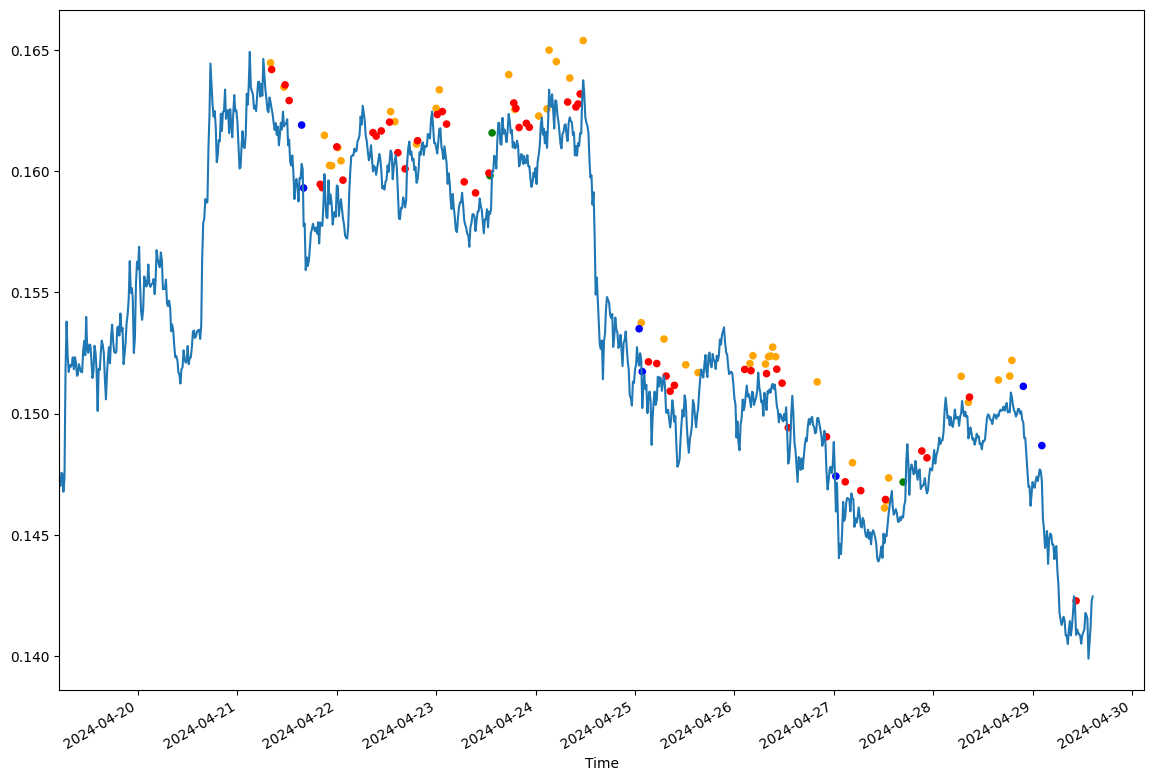

(100, 0.1)

In [2]:
import matplotlib.pyplot as plt
import os
while not os.path.isfile('config.yaml'):
    os.chdir("../")
import yaml
with open('./config.yaml', 'r') as f:
    config = yaml.safe_load(f)

from api.api import Api
api = Api.create_api(config)

def goes_up(symbol, data, index, upper_limit, lower_limit, side):
    price_precision,_ = api.get_precisions(symbol)
    upper_limit = round(upper_limit, price_precision)
    lower_limit = round(lower_limit, price_precision)

    for i in range(index, index + 7):
        if data.High[i] >= upper_limit and data.Low[i] > lower_limit:
            return 1
        if data.Low[i] <= lower_limit and data.High[i] < upper_limit:
            return -1
        if data.High[i] >= upper_limit and data.Low[i] <= lower_limit:
            start_time = int(data.index[i].timestamp() * 1000)
            finer_data = api.start_timed_klines(symbol=symbol, start_time=start_time)
            for n in range(15):
                if finer_data.High[n] >= upper_limit and finer_data.Low[n] > lower_limit:
                    return 1
                if finer_data.Low[n] <= lower_limit and finer_data.High[n] < upper_limit:
                    return -1
                if side == 1:
                    if finer_data.Low[n] <= lower_limit:
                        return 0
                if side == -1:
                    if finer_data.High[n] >= upper_limit:
                        return 0
            return 0
        if side == 1:
            if data.Low[i] <= lower_limit:
                return 0
        if side == -1:
            if data.High[i] >= upper_limit:
                return 0
    return 0

def backtest(data, predictor, sl, tp, window_size, symbol):
    compensation = config['general']['compensation']
    nwindows = len(data) - window_size
    success = 0 
    fail = 0 
    buys = []
    sells = []
    for i in range(nwindows - 11):
        data_window = data.iloc[i:i + window_size]
        prediction = predictor(data_window)
        if prediction == 1:
            if 1 == goes_up(symbol, data, i + window_size, data.Close[i + window_size - 1] * (1 + compensation) * (1 + tp), data.Close[i + window_size - 1] * (1 + compensation) * (1 - sl), 1):
                success += 1
                buys.append([data.index[i+window_size], data.Close[i+window_size] * 1.01, 1])
            else:
                fail += 1
                buys.append([data.index[i+window_size], data.Close[i+window_size] * 1.01, 0])
        elif prediction == -1: 
            if -1 == goes_up(symbol, data, i + window_size, data.Close[i + window_size - 1] * (1 - compensation) * (1 + sl), data.Close[i + window_size - 1] * (1 - compensation) * (1 - tp), -1):
                sells.append([data.index[i+window_size], data.Close[i+window_size] * 1.01, 1])
                success += 1
            else:
                fail += 1
                sells.append([data.index[i+window_size], data.Close[i+window_size] * 1.01, 0])
    return (nwindows, success, fail, buys, sells) 

import os
while not os.path.isfile('config.yaml'):
    os.chdir("../")
import strategies as strategies
import yaml
from api.api import Api
with open('./config.yaml', 'r') as f:
    config = yaml.safe_load(f)
api = Api.create_api(config)

sym = 'DOGEUSDT'
data = api.klines(sym,15,limit=1000)
nwin,suc,fails,buys,sells = backtest(data, strategies.martin_4,0.01,0.02,200, sym)

def unziper(a):
    a1, a2, a3 = [], [], []
    for e in a:
        a1.append(e[0])
        a2.append(e[1])
        a3.append(e[2])
    return a1, a2, a3

buys = unziper(buys)
sells = unziper(sells)

buy_col = ['green' if x else 'orange' for x in buys[2]]
sell_col = ['blue' if x else 'red' for x in sells[2]]

cutoff=0
data.Close[cutoff:].plot(figsize=(14,10))
plt.scatter(buys[0], buys[1], c=buy_col, s=20)
plt.scatter(sells[0], sells[1], c=sell_col, s=20)
plt.xlim(left=data.index[cutoff])
plt.show()
suc + fails, suc / (suc + fails)

## Metrics numerical values

In [3]:
import yaml
import os
while not os.path.isfile('config.yaml'):
    os.chdir("../")
from api.api import Api
with open('./config.yaml', 'r') as f:
    config = yaml.safe_load(f)
api = Api.create_api(config)
from helpers.helpers import filtered_symbols 
import ta

symbols = filtered_symbols(api, config) 

for symbol in symbols:
    data_window = api.klines(symbol, limit=200)
    a = ta.volatility.AverageTrueRange(data_window.High, data_window.Low, data_window.Close).average_true_range()
    a = a / a.std()
    print(a.mean(), a.min(), a.max())


In [ ]:
data = api.klines('BTCUSDT', limit=200)

In [ ]:
ta.add_all_ta_features(df=data, open='Open', high="High", low="Low", close="Close", volume="Volume", fillna=True)